In [ ]:
!pip install qiskit

In [ ]:
# !pip install qiskit-aer-gpu
!pip install umap-learn

In [2]:
from qiskit import *
import numpy as np
import os
import time
import pickle
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap, PauliFeatureMap
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import VQC
from qiskit.circuit.library import EfficientSU2, RealAmplitudes
from qiskit.aqua.components.optimizers import COBYLA
import umap
import pickle

In [3]:
!unzip -d mnist_train ./mnist_train.csv.zip
!mv mnist_train/mnist_train.csv mnist_train.csv 

Archive:  ./mnist_train.csv.zip
  inflating: mnist_train/mnist_train.csv  
replace mnist_train/__MACOSX/._mnist_train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [11]:
# importing some useful modules
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

image_size = 28 # width and length are equal

data_path = "./"
train_data = np.loadtxt(data_path + "mnist_train.csv", delimiter=",")
test_data = np.loadtxt(data_path + "mnist_test.csv", delimiter=",") 

In [12]:
random_indices = np.random.choice(60000, size=10000, replace=False)
# train_data = train_data[random_indices]

train_data_features = train_data[:10000, 1:]
train_data_labels = train_data[:10000, :1].reshape(10000,)

In [13]:
feature_dim = 2

In [14]:
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Using SVD to bring down the dimension to 10
tsvd = TruncatedSVD(n_components=20)
X_SVD = tsvd.fit_transform(train_data_features)

# Further using t-SNE to bring the dimension down to {feature_dim}
np.random.seed(0)
# tsne = TSNE(n_components=feature_dim)
um = umap.UMAP()
# tsne = PCA(n_components=2)
# embedder = cvae.CompressionVAE(X_SVD)
# embedder.train()
# train_data_features_reduced = embedder.embed(X_SVD)
train_data_features_reduced = um.fit_transform(X_SVD)

In [15]:
pickle.dump(tsvd,open('tsvd_transforms.pkl','wb'))
pickle.dump(um,open('umap_transforms.pkl','wb'))

In [16]:
import seaborn as sns
import pandas as pd

# function to help plot the 2-D dataset
def plot2d(X, Y, c1, c2, N):
    lbl1 = f'Component {c1}'
    lbl2 = f'Component {c2}'    
    df = pd.DataFrame({lbl1:X[:N,c1], lbl2:X[:N,c2], 'label':Y[:N]})
    sns.lmplot(data=df, x=lbl1, y=lbl2, fit_reg=False, hue='label', scatter_kws={'alpha':0.5})   

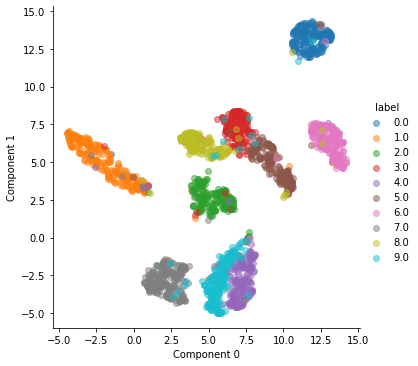

In [17]:
plot2d(train_data_features_reduced, train_data_labels, 0, 1, N=2000)

In [18]:
def getZFeatureMap(reps):
    return ZFeatureMap(feature_dimension=feature_dim, reps=reps)
def getZZFeatureMap(reps,mode='linear'):
    return ZZFeatureMap(feature_dimension=feature_dim, reps=reps, entanglement=mode)

def getPauliFeatureMap(reps):
    return PauliFeatureMap(feature_dimension=feature_dim, reps=reps, paulis = ['Z','X','ZY'])

    
def getFourNineFeatureMap():
    pass

def get_feature_maps():
    
    reps_lis = [1,2,4]
    modes = ['full','linear']
    maps = [getZFeatureMap,getZZFeatureMap,getPauliFeatureMap]
    feature_maps = []
    for rep in reps_lis:
        for i in range(len(maps)):
            if(i==1):
                for mode in modes:
                    feature_maps.append(maps[i](rep,mode=mode))
            else:
                feature_maps.append(maps[i](rep))
    return feature_maps

In [19]:
def get_variational_circs():
    reps_lis = [1,2,4]
    circs = []
    
    for i in reps_lis:
        circs.append(EfficientSU2(feature_dim,reps=i))
    return circs

In [20]:
def get_dataset(classOne =[0,3,5,6,8],classTwo=[1,2,4,7,9]):

    zero_datapoints = []
    one_datapoints = []

    for i in range(10000):
        if train_data_labels[i] in classOne:                   # extracting zeros
            zero_datapoints.append(train_data_features_reduced[i])

    for i in range(10000):
        if train_data_labels[i] in classTwo:                   # extracting ones
            one_datapoints.append(train_data_features_reduced[i])

    zero_datapoints = np.array(zero_datapoints)
    one_datapoints = np.array(one_datapoints)

    def normalize(arr, max_val, n):
        a = np.divide(arr, max_val)
        return a + n

    zero_datapoints_normalized = normalize(zero_datapoints, 100, 1)
    one_datapoints_normalized = normalize(one_datapoints, 100, 1)
    
    
    train_size = 50
    test_size = 800
    dp_size_zero = 5
    dp_size_one = 5

    zero_train = zero_datapoints_normalized[:train_size]
    one_train = one_datapoints_normalized[:train_size]

    zero_test = zero_datapoints_normalized[train_size + 1:train_size + test_size + 1]
    one_test = one_datapoints_normalized[train_size + 1:train_size + test_size + 1]

    training_input = {'A':zero_train, 'B':one_train}
    test_input = {'A':zero_test, 'B':one_test}

    # datapoints is our validation set
    datapoints = []
    dp_zero = zero_datapoints_normalized[train_size + test_size + 2:train_size + test_size + 2 + dp_size_zero]
    dp_one = one_datapoints_normalized[train_size + test_size + 2:train_size + test_size + 2 + dp_size_one]
    datapoints.append(np.concatenate((dp_zero, dp_one)))
    dp_y = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])
    datapoints.append(dp_y)

    class_to_label = {'A': 0, 'B': 1}
    return training_input,test_input,datapoints

In [8]:
from qiskit import BasicAer
from qiskit import Aer, IBMQ
from qiskit.providers.ibmq import least_busy

seed = 2041

# initilizing our backend
# choose using var - backend_value
if backend_value == 'qasm_simulator':
    backend = BasicAer.get_backend('qasm_simulator')
    # backend = AerSimulator()
    backend_options = {"method": "statevector"}
elif backend_value == 'statevector_simulator':
    backend = Aer.get_backend("statevector_simulator")
    backend_options = {"method": "statevector"}
    pass
elif backend_value == 'IBMQ':
    # The account must be configured before running on a real quantum computer
    IBMQ.load_account()
    provider = IBMQ.get_provider(hub='ibm-q')
    backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (n+1) and
                                   not x.configuration().simulator and x.status().operational==True))
    print("least busy backend: ", backend)
    pass

# creating a quantum instance
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed,backend_options=backend_options)

def call_back_vqc(eval_count, var_params, eval_val, index):
    print("eval_count: {}".format(eval_count))
    print("var_params: {}".format(var_params))
    print("eval_val: {}".format(eval_val))
    print("index: {}".format(index))
    
cobyla = COBYLA(maxiter=500, tol=0.001)

NameError: name 'QuantumInstance' is not defined

In [22]:
def train_all(exp_name):
    exp_name = f'results/{exp_name}'
    if(not os.path.exists(exp_name)):
        os.mkdir(exp_name)
    
    f_maps = get_feature_maps()
    var_circs = get_variational_circs()

    # Modify This
    training_input,test_input,datapoints = get_dataset([0,6,3,5,8],[1,2,4,7,9])
    
    
    for i,map in enumerate(f_maps):
        for j,circ in enumerate(var_circs):
            vqc = VQC(optimizer=cobyla, feature_map=map, var_form=circ, callback=call_back_vqc, training_dataset=training_input, 
                 test_dataset=test_input, datapoints=datapoints[0])
            result = vqc.run(quantum_instance)
            print("testing success ratio: {}".format(result['testing_accuracy']))
            pickle.dump(vqc,open(f'{exp_name}/model_{result["testing_accuracy"]}_params_{i}_{j}','wb'))
            

In [24]:
if(not os.path.exists('results')):
    os.mkdir('results')
train_all('0,3,5,6,8')

eval_count: 0
var_params: [ 0.3471417   0.39300178 -0.43175023 -0.2096616  -1.14222536  0.20020447
 -0.57610098  1.70762375]
eval_val: 0.9183562066736486
index: 0
eval_count: 1
var_params: [ 1.3471417   0.39300178 -0.43175023 -0.2096616  -1.14222536  0.20020447
 -0.57610098  1.70762375]
eval_val: 0.8423357095014556
index: 1
eval_count: 2
var_params: [ 1.3471417   1.39300178 -0.43175023 -0.2096616  -1.14222536  0.20020447
 -0.57610098  1.70762375]
eval_val: 0.7209179138232984
index: 2
eval_count: 3
var_params: [ 1.3471417   1.39300178  0.56824977 -0.2096616  -1.14222536  0.20020447
 -0.57610098  1.70762375]
eval_val: 0.6500513638836355
index: 3
eval_count: 4
var_params: [ 1.3471417   1.39300178  0.56824977  0.7903384  -1.14222536  0.20020447
 -0.57610098  1.70762375]
eval_val: 0.6360654735644573
index: 4


KeyboardInterrupt: ignored

In [88]:
!git clone https://github.com/jsilter/parametric_tsne.git

Cloning into 'parametric_tsne'...
remote: Enumerating objects: 150, done.
remote: Total 150 (delta 0), reused 0 (delta 0), pack-reused 150
Receiving objects: 100% (150/150), 5.04 MiB | 29.16 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [89]:
cp -R ./parametric_tsne/parametric_tSNE/ parametric_tsnee/

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import tensorflow
print(tensorflow.__version__)

1.15.2


In [9]:
from parametric_tsne import Parametric_tSNE

In [4]:
rm -r ./parametric_tsne/

In [6]:
!touch __init__.py

In [8]:
import parametric_tsne

In [12]:
p = Parametric_tSNE(train_data.shape[1], 10, 30)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [11]:
import numpy as np
train_data = np.random.randn(10,784)


In [16]:
p.fit(training_data=train_data)

ValueError: ignored

In [15]:
train_data

array([[-1.65472395,  0.83185362,  1.77464489, ..., -0.25428918,
         0.75344941,  2.05642519],
       [-0.30253136,  1.47756364,  1.27179187, ...,  0.04528566,
         1.06792173,  0.39534342],
       [ 0.46558023,  1.08251561, -0.24469556, ..., -0.77357005,
        -0.88447958, -0.4354401 ],
       ...,
       [-2.23813998, -1.58856087,  0.9669512 , ..., -0.67228345,
         0.10621301, -0.52786531],
       [ 0.00957105,  0.02729743,  1.98028935, ...,  0.26321637,
         0.71645035, -1.1698798 ],
       [ 1.14530492, -0.06135496,  2.24858752, ...,  0.05528252,
        -0.91901377,  1.92732586]])

In [17]:
!pip install cvae


  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=983c1a69000e32cd25b62c1a120bd2b69cd981ba1ef4ba0de217a71896634b18
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3


In [18]:
from cvae import cvae

In [19]:
embedder = cvae.CompressionVAE(train_data)

Total amount of data:  9
Input feature dimension:  784
Calculating normalisation factors.
Normalisation factors calculated.
Total amount of data:  1
Creating model.
Model created.
Setting up loss.
Loss set up.
Setting up session.
Session set up.
Trying to restore saved checkpoints from /content/temp ... No checkpoint found.
No model found to restore. Initialising new model.


In [23]:
embedder.train()

Starting queues.
Reader threads started.
step 0; epoch 0.00 - loss = 394.412, test_loss = 686.862, lr = 0.00100, (0.022 sec/step)
Storing checkpoint to /content/temp ... Done.
step 50; epoch 355.56 - loss = 237.535, test_loss = 690.283, lr = 0.00100, (0.001 sec/step)
step 100; epoch 711.11 - loss = 202.224, test_loss = 738.240, lr = 0.00100, (0.001 sec/step)
step 150; epoch 1066.67 - loss = 120.304, test_loss = 795.693, lr = 0.00100, (0.001 sec/step)
step 200; epoch 1422.22 - loss = 56.384, test_loss = 911.957, lr = 0.00100, (0.001 sec/step)
No improvement on validation data for 5 test steps. Decreasing learning rate by factor 5
step 250; epoch 1777.78 - loss = 48.523, test_loss = 894.878, lr = 0.00020, (0.001 sec/step)
No improvement on validation data for 5 test steps. Decreasing learning rate by factor 5
step 300; epoch 2133.33 - loss = 40.867, test_loss = 918.806, lr = 0.00004, (0.001 sec/step)
No improvement on validation data for 5 test steps. Decreasing learning rate by factor 5

In [24]:
embedder.embed(train_data)

array([[ 0.61665404, -0.06329355],
       [ 0.0460065 , -0.29073995],
       [ 3.4492702 , -1.7244976 ],
       [ 0.2228914 ,  1.2268927 ],
       [-2.9376993 , -2.775878  ],
       [-0.31922108, -1.2828491 ],
       [ 2.79491   ,  2.216765  ],
       [-1.9340822 ,  0.07419849],
       [ 0.92807066, -3.9515128 ],
       [-1.4548671 ,  2.8267207 ]], dtype=float32)